In [1]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

In [24]:
data = pd.read_csv('DailyDelhiClimateTrain.csv')
test = pd.read_csv('DailyDelhiClimateTest.csv')
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


# Feature Engineering

In [25]:
#Convert date to datetime
data['date'] = pd.to_datetime(data['date'])
test['date'] = pd.to_datetime(test['date'])

In [26]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day

In [27]:
data.tail()

,date,meantemp,humidity,wind_speed,meanpressure,year,month,day
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,2016,12,28
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,2016,12,29
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,2016,12,30
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,2016,12,31
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000,2017,1,1


In [28]:
#Check if the interval is consistant
data = data.sort_values(by='date')
test = test.sort_values(by='date')
data['delta'] = data['date'] - data['date'].shift(1)
data[['date','delta']].head()

,date,delta
0,2013-01-01,NaT
1,2013-01-02,1 days
2,2013-01-03,1 days
3,2013-01-04,1 days
4,2013-01-05,1 days


In [8]:
#Check for missing values
data = data.drop('delta',axis=1)
data.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
year            0
month           0
day             0
dtype: int64

# Visualizing our data

Text(0, 0.5, 'Mean pressure')

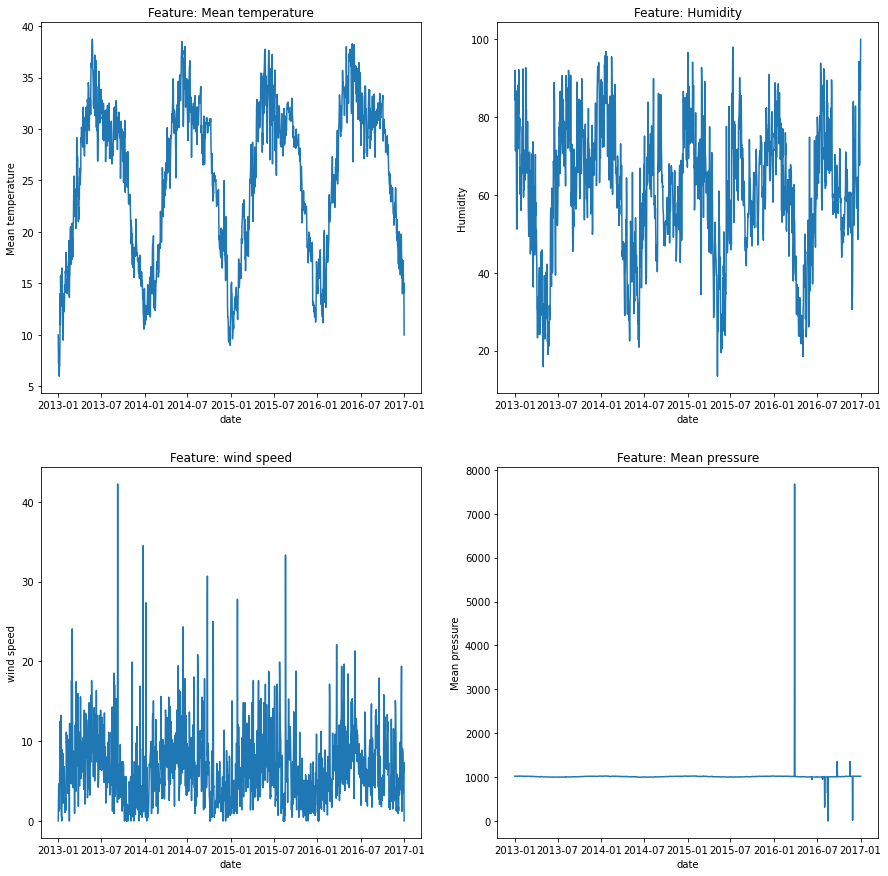

In [9]:
f,ax = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
sns.lineplot(x=data['date'], y=data['meantemp'],ax=ax[0][0])
ax[0,0].set_title('Feature: Mean temperature')
ax[0,0].set_ylabel(ylabel='Mean temperature')

sns.lineplot(x=data['date'], y=data['humidity'],ax=ax[0][1])
ax[0,1].set_title('Feature: Humidity')
ax[0,1].set_ylabel(ylabel='Humidity')

sns.lineplot(x=data['date'], y=data['wind_speed'],ax=ax[1][0])
ax[1,0].set_title('Feature: wind speed')
ax[1,0].set_ylabel(ylabel='wind speed')

sns.lineplot(x=data['date'], y=data['meanpressure'],ax=ax[1][1])
ax[1,1].set_title('Feature: Mean pressure')
ax[1,1].set_ylabel(ylabel='Mean pressure')

# Smoothing the data

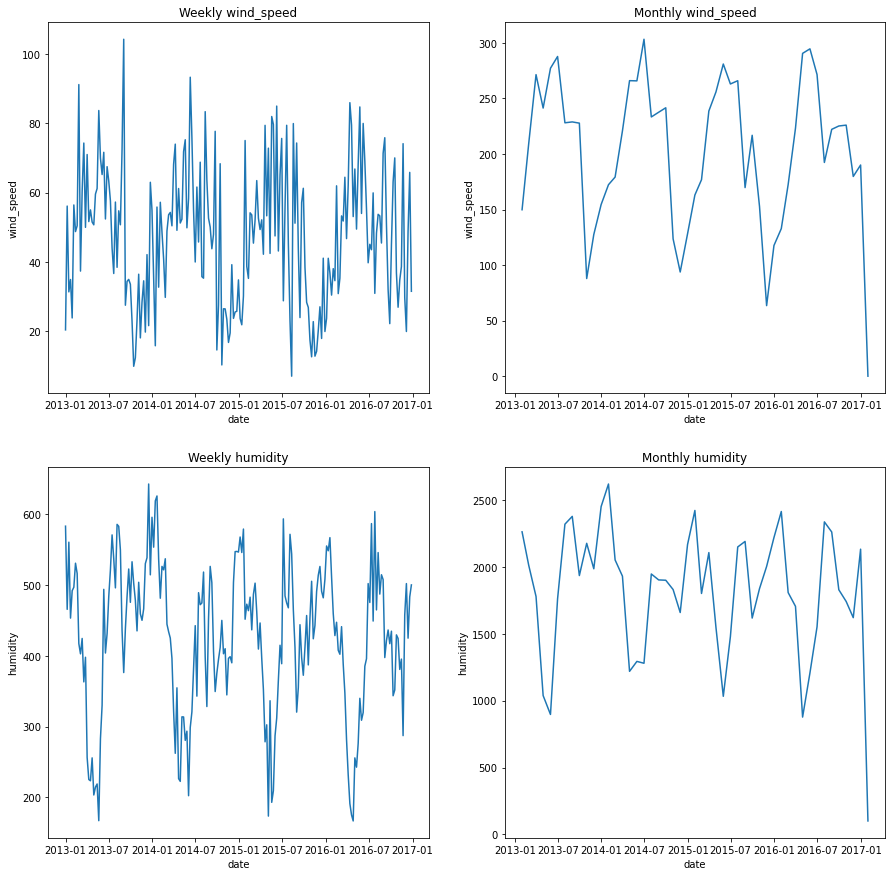

In [10]:
#Take an example with wind speed and humidity
f,ax = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
resampled = data[['date','wind_speed']].resample('7D',on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled['date'], y=resampled['wind_speed'],ax=ax[0][0])
ax[0][0].set_title('Weekly wind_speed')
resampled = data[['date','wind_speed']].resample('M',on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled['date'], y=resampled['wind_speed'],ax=ax[0][1])
ax[0][1].set_title('Monthly wind_speed')

resampled = data[['date','humidity']].resample('7D',on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled['date'], y=resampled['humidity'],ax=ax[1][0])
ax[1][0].set_title('Weekly humidity')
resampled = data[['date','humidity']].resample('M',on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled['date'], y=resampled['humidity'],ax=ax[1][1])
ax[1][1].set_title('Monthly humidity')

plt.show()

We can observe that downsampling the data weekly will smooth the data

In [33]:
data_down = data[['date','meantemp','humidity','wind_speed','meanpressure']].resample('7D',on='date').mean().reset_index(drop=False)
test_down = test[['date','meantemp','humidity','wind_speed','meanpressure']].resample('7D',on='date').mean().reset_index(drop=False)

# Check stationarity

First we are going to check it visually

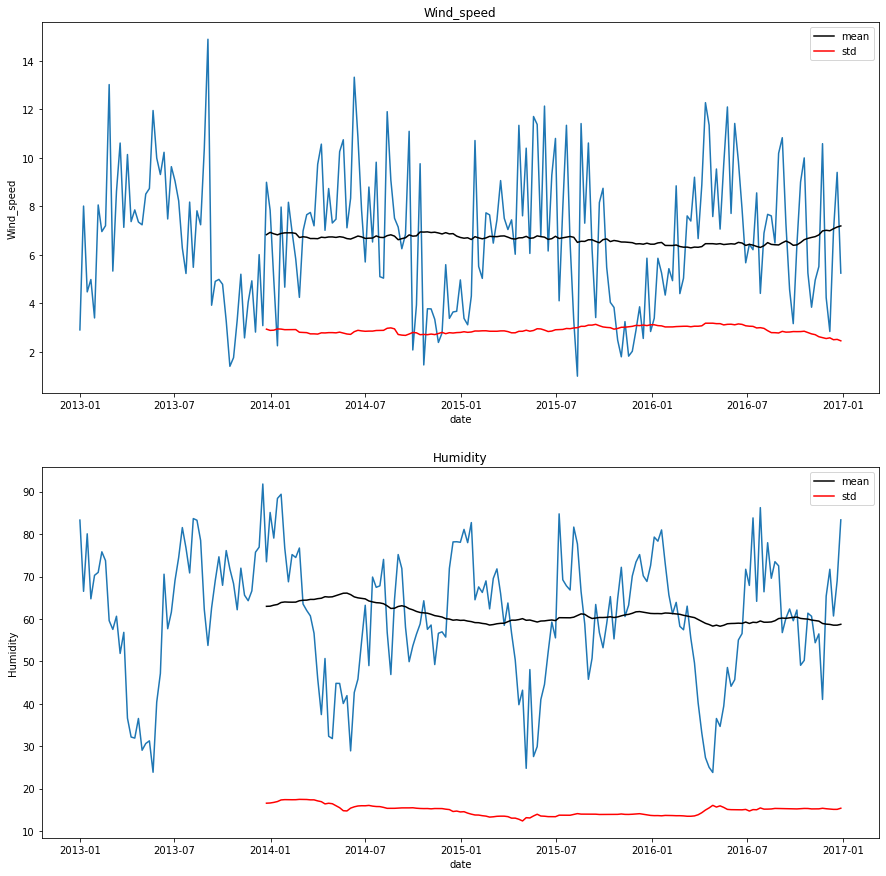

In [12]:
f,ax = plt.subplots(nrows=2, ncols=1,figsize=(15,15))

sns.lineplot(x=data_down['date'], y=data_down['wind_speed'],ax=ax[0])
sns.lineplot(x=data_down['date'], y=data_down['wind_speed'].rolling(52).mean(),ax=ax[0],color='black',label='mean')
sns.lineplot(x=data_down['date'], y=data_down['wind_speed'].rolling(52).std(),ax=ax[0],color='red',label='std')
ax[0].set_title('Wind_speed')
ax[0].set_ylabel('Wind_speed')

sns.lineplot(x=data_down['date'], y=data_down['humidity'],ax=ax[1])
sns.lineplot(x=data_down['date'], y=data_down['humidity'].rolling(52).mean(),ax=ax[1],color='black',label='mean')
sns.lineplot(x=data_down['date'], y=data_down['humidity'].rolling(52).std(),ax=ax[1],color='red',label='std')
ax[1].set_title('Humidity')
ax[1].set_ylabel('Humidity')


plt.show()

Visually we can see that the mean and std are almost constant

Now let's check it statistically using Augmented Dickey-Fuller(ADF)

ADF is one type of statistical test called a unit root test. Unit roots are a cause of non-stationarity.
**Null Hypothesis(H0)**: The time series has a unit root which means it is not stationary
**Alternate Hypothesis(H1)**: The time series has no unit root, therefore it is stationary
If the null hypothesis can be rejected, than we can affirm that it is stationary.

**H0** can be rejected if p-value is below a certain level of significance(by default we use 5%)

**H0** can also be rejected if ADF statistic is less than the critical value


In [13]:
#Checking it with wind_speed feature

from statsmodels.tsa.stattools import adfuller

adfuller(data_down['wind_speed'].values)

(-3.092461343906895,
 0.027116136355343733,
 4,
 204,
 {'1%': -3.462818103072159,
  '5%': -2.8758145932936805,
  '10%': -2.574378674548251},
 895.7981290192058)

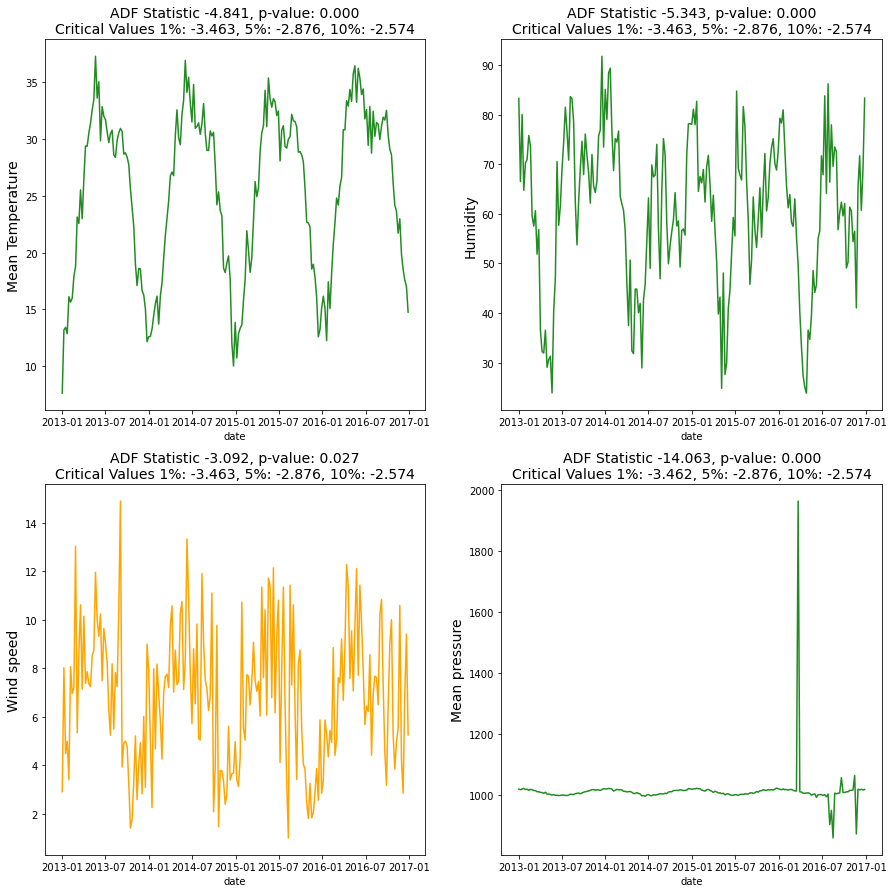

In [14]:
#The function is from https://www.kaggle.com/iamleonie
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=data_down['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(data_down['meantemp'].values,'Mean Temperature',ax[0][0])
visualize_adfuller_results(data_down['humidity'].values,'Humidity',ax[0][1])
visualize_adfuller_results(data_down['wind_speed'].values,'Wind speed',ax[1][0])
visualize_adfuller_results(data_down['meanpressure'].values,'Mean pressure',ax[1][1])



We can state that our features are relatively stationary

If they were not stationary, we could have transformed them into stationary.
Either by transformation(using log or square root to stabilize non-constant variance) or differencing(substracting the current value from the previous)

In [15]:
#Checking the level,trend,seasonality and noise of our time series
from statsmodels.tsa.seasonal import seasonal_decompose
columns = ['meantemp','humidity','wind_speed','meanpressure']
for column in columns:
    decomp = seasonal_decompose(data_down[column],period=52,model='additive',extrapolate_trend='freq')
    data_down[f'{column}_trend'] = decomp.trend
    data_down[f'{column}_seasonal'] = decomp.seasonal

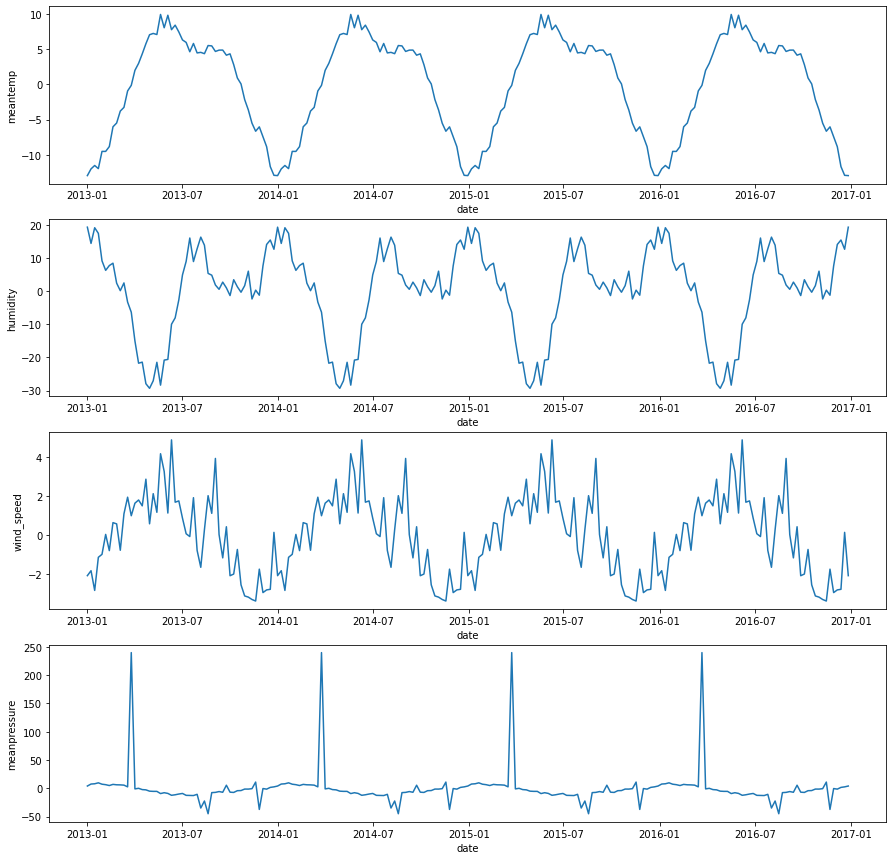

In [16]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))

for i, column in enumerate(columns):
    sns.lineplot(x=data_down['date'], y=data_down[column +'_seasonal'],ax=ax[i])
    ax[i].set_ylabel(ylabel=column)
#plt.tight_layout
plt.show()


# Univariate

Let's try to predict one feature

In [17]:
from datetime import date

In [18]:
from sklearn.model_selection import TimeSeriesSplit

x = data_down['date']
y = data_down['wind_speed']
folds = TimeSeriesSplit(n_splits=3)

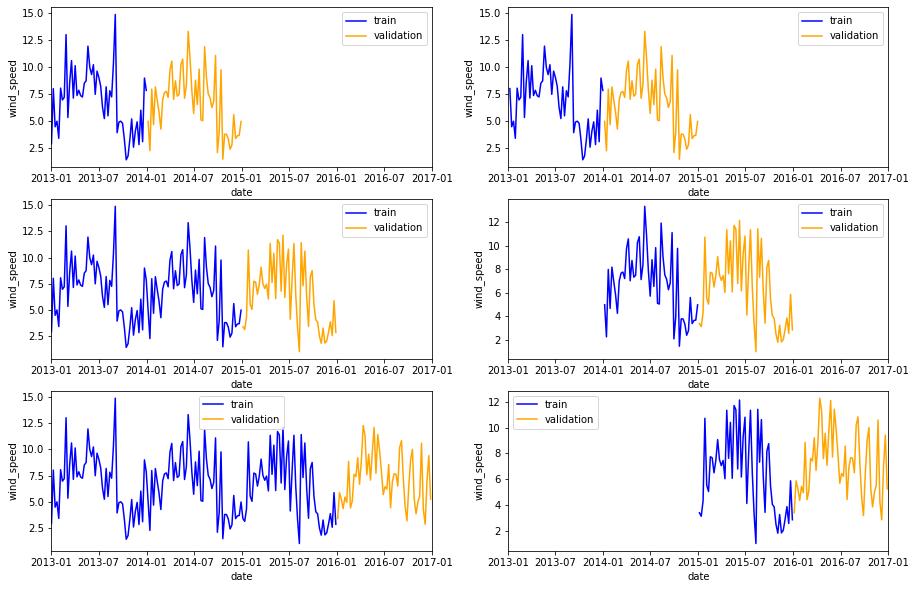

In [19]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

for i, (train_index, valid_index) in enumerate(folds.split(x)):
    x_train,x_valid = x[train_index],x[valid_index]
    y_train,y_valid = y[train_index], y[valid_index]
    
    sns.lineplot(x=x_train,y=y_train,ax=ax[i][0],color='blue',label='train')
    sns.lineplot(x=x_train[len(x_train)-len(x_valid):(len(x_train)-len(x_valid)+len(x_valid))],
                 y=y_train[len(x_train)-len(x_valid):(len(x_train)-len(x_valid)+len(x_valid))],
                 ax=ax[i,1],color='blue',label='train')
    
    for j in range(2):
        sns.lineplot(x=x_valid,y=y_valid,ax=ax[i,j],color='orange',label='validation')

    for i in range(3):
        ax[i,0].set_xlim([date(2013,1,1),date(2017,1,1)])
        ax[i,1].set_xlim([date(2013,1,1),date(2017,1,1)])
plt.show()

In [34]:
train = data_down[['date','wind_speed']]
test1 = test_down[['date','wind_speed']]

# Prophet

Prophet is open-source library for time series forecasting developed by facebook
Its implementation supports trends and seasonality

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from fbprophet import Prophet

In [36]:
train.columns = ['ds','y']
test1.columns = ['ds','y']

In [55]:
together = pd.concat([train,test1])

In [57]:
train_size = len(train)
train = together.iloc[:train_size,:]
x_train, y_train = pd.DataFrame(together.iloc[:train_size,0]),pd.DataFrame(together.iloc[:train_size,1])
x_test,y_test = pd.DataFrame(together.iloc[train_size:,0]),pd.DataFrame(together.iloc[train_size:,1])

In [58]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
y_pred = model.predict(x_test)

In [66]:
mae = mean_absolute_error(y_test,y_pred['yhat'])
rmse = math.sqrt(mean_squared_error(y_test,y_pred['yhat']))
print(Fore.GREEN + 'MAE:{}'.format(mae))
print(Fore.GREEN + 'RMSE:{}'.format(rmse))

MAE:1.5551515958334317
RMSE:1.9883198605633465


Text(111.25, 0.5, 'wind Speed')

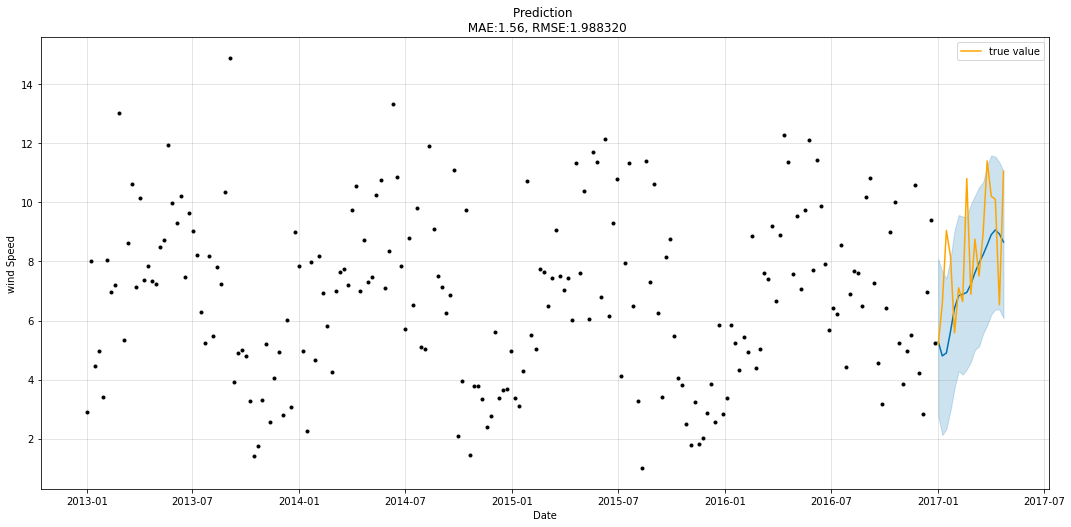

In [71]:
f,ax = plt.subplots(1,figsize=(15,7))

model.plot(y_pred,ax=ax)

sns.lineplot(x=x_test['ds'],y=y_test['y'],ax = ax,color='orange',label='true value')
ax.set_title(f'Prediction \n MAE:{mae:.2f}, RMSE:{rmse:2f}')
ax.set_xlabel('Date')
ax.set_ylabel('wind Speed')

# ARIMA

The second model we are going to try is ARIMA. Auto_Regressive Integrated Moving Average describes the autocorrelations in the data. It assumes that the time series is stationary.
To choose its parameter p,d and q, we can use auto arima to help us.
Note: The time series should be stationary

In [74]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [106]:
model = pm.auto_arima(y_train,start_p=1,start_q=1,test='adf',#using adftest to find optimal d
                     max_p=3,max_q=3, # Maximum p and q
                     m=1, #Let the model determine
                     d=None,# we let the model determine it
                     seasonal=False,
                     start_P=0,D=0, trace=True,
                     error_action='ignore',
                     suppress_warnings=True,stepwise=True)
print(model.summary)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=982.990, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1066.159, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1026.610, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=980.991, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1064.162, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=982.990, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=982.578, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=978.999, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=980.999, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=980.998, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1024.616, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=980.585, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.587 seconds
<function ARIMA.summary at 0x0000016854E5D268>


The best model is ARIMA(0,1,1). So we will use these parameters.

In [104]:
model = ARIMA(y_train,order=(0,1,1))
model_arima = model.fit()

In [105]:
y_pred, se, conf = model_arima.forecast(len(x_test))
mae = mean_absolute_error(y_test,y_pred)
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
print('MAE:{}'.format(mae))
print('RMSE:{}'.format(rmse))

MAE:2.0873642303437885
RMSE:2.6463991034386396


In [84]:
len(x_train)

209

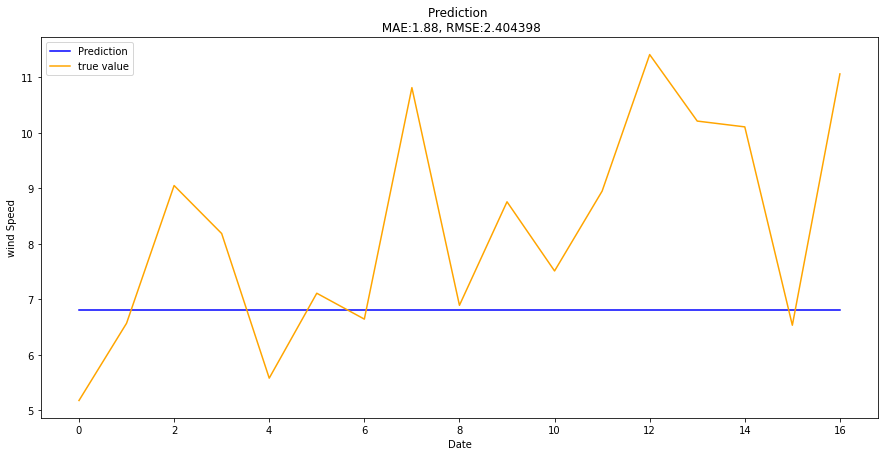

In [99]:
f,ax = plt.subplots(1,figsize=(15,7))

#model_arima.plot_predict(1,208,ax=ax)
sns.lineplot(x=x_test.index,y=y_pred,ax = ax,color='blue',label='Prediction')
sns.lineplot(x=x_test.index,y=y_test['y'],ax = ax,color='orange',label='true value')
ax.set_title(f'Prediction \n MAE:{mae:.2f}, RMSE:{rmse:2f}')
ax.set_xlabel('Date')
ax.set_ylabel('wind Speed')
plt.show()

Prophet seems to have a better prediction than ARIMA

One could decide to go further using an LSTM model to have a better prediction, which we will do in a near future